### Plotting PTMs in Comet and PEAKS results using python for ETNP OM study

Starting with:

    Peaks de novo results (.csv) of PTM-optimized sequencing
    Comet results from PTM-optimized database searches

Goal:

    Figures comparing the modifcation type and extent in database and de novo peptides
    
Using:

    - pandas
    - matplotlib
    - numpy

In [1]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

In [2]:
# read in csvs made in SKQ17-PeaksDN nbs with NAAF corrected AAs (PTMs in there, too)

peaks231_NAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_PTMopt_DN50_AA_NAAF.csv")
peaks231_NAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-231-100m-0.3-JA2_PTMopt_DN80_AA_NAAF.csv")

peaks233_NAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-233-265m-0.3-JA4_PTMopt_DN50_AA_NAAF.csv")
peaks233_NAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-233-265m-0.3-JA4_PTMopt_DN80_AA_NAAF.csv")

peaks243_NAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-243-965m-0.3-JA14_PTMopt_DN50_AA_NAAF.csv")
peaks243_NAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-243-965m-0.3-JA14_PTMopt_DN80_AA_NAAF.csv")

peaks378_NAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-378-100m-trap_PTMopt_DN50_AA_NAAF.csv")
peaks378_NAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-378-100m-trap_PTMopt_DN80_AA_NAAF.csv")

peaks278_NAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-278-265m-trap_PTMopt_DN50_AA_NAAF.csv")
peaks278_NAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-278-265m-trap_PTMopt_DN80_AA_NAAF.csv")

peaks273_NAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-273-965m-trap_PTMopt_DN50_AA_NAAF.csv")
peaks273_NAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-273-965m-trap_PTMopt_DN80_AA_NAAF.csv")

# there's a useless column in there to get rid of
peaks231_NAAF50 = peaks231_NAAF50.loc[:, ~peaks231_NAAF50.columns.str.contains('^Unnamed')]
peaks231_NAAF80 = peaks231_NAAF80.loc[:, ~peaks231_NAAF80.columns.str.contains('^Unnamed')]

peaks233_NAAF50 = peaks233_NAAF50.loc[:, ~peaks233_NAAF50.columns.str.contains('^Unnamed')]
peaks233_NAAF80 = peaks233_NAAF80.loc[:, ~peaks233_NAAF80.columns.str.contains('^Unnamed')]

peaks243_NAAF50 = peaks243_NAAF50.loc[:, ~peaks243_NAAF50.columns.str.contains('^Unnamed')]
peaks243_NAAF80 = peaks243_NAAF80.loc[:, ~peaks243_NAAF80.columns.str.contains('^Unnamed')]

peaks378_NAAF50 = peaks378_NAAF50.loc[:, ~peaks378_NAAF50.columns.str.contains('^Unnamed')]
peaks378_NAAF80 = peaks378_NAAF80.loc[:, ~peaks378_NAAF80.columns.str.contains('^Unnamed')]

peaks278_NAAF50 = peaks278_NAAF50.loc[:, ~peaks278_NAAF50.columns.str.contains('^Unnamed')]
peaks278_NAAF80 = peaks278_NAAF80.loc[:, ~peaks278_NAAF80.columns.str.contains('^Unnamed')]

peaks273_NAAF50 = peaks273_NAAF50.loc[:, ~peaks273_NAAF50.columns.str.contains('^Unnamed')]
peaks273_NAAF80 = peaks273_NAAF80.loc[:, ~peaks273_NAAF80.columns.str.contains('^Unnamed')]


In [70]:
# read in csvs made in SKQ17-Comet nbs with NAAF corrected AAs (PTMs in there, too)

comet231_NAAF = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/TPP-PTMopt/ETNP-SKQ17-TPP-PTMopt-hyroxylation/ETNP-SKQ17-231-100m-0.3-JA2_PTMopt_Comet3_AA_NAAF.csv")

comet233_NAAF = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/TPP-PTMopt/ETNP-SKQ17-TPP-PTMopt-hyroxylation/ETNP-SKQ17-233-265m-0.3-JA4_PTMopt_Comet3_AA_NAAF.csv")

comet243_NAAF = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/TPP-PTMopt/ETNP-SKQ17-TPP-PTMopt-hyroxylation/ETNP-SKQ17-243-965m-0.3-JA14_PTMopt_Comet3_AA_NAAF.csv")

comet378_NAAF = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/TPP-PTMopt/ETNP-SKQ17-TPP-PTMopt-hyroxylation/ETNP-SKQ17-378-100m-trap_PTMopt_Comet3_AA_NAAF.csv")

comet278_NAAF = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/TPP-PTMopt/ETNP-SKQ17-TPP-PTMopt-hyroxylation/ETNP-SKQ17-278-265m-trap_PTMopt_Comet3_AA_NAAF.csv")

comet273_NAAF = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/TPP-PTMopt/ETNP-SKQ17-TPP-PTMopt-hyroxylation/ETNP-SKQ17-273-965m-trap_PTMopt_Comet3_AA_NAAF.csv")

# there's a useless column in there to get rid of
comet231_NAAF = comet231_NAAF.loc[:, ~comet231_NAAF.columns.str.contains('^Unnamed')]
comet233_NAAF = comet233_NAAF.loc[:, ~comet233_NAAF.columns.str.contains('^Unnamed')]
comet243_NAAF = comet243_NAAF.loc[:, ~comet243_NAAF.columns.str.contains('^Unnamed')]
comet378_NAAF = comet378_NAAF.loc[:, ~comet378_NAAF.columns.str.contains('^Unnamed')]
comet278_NAAF = comet278_NAAF.loc[:, ~comet278_NAAF.columns.str.contains('^Unnamed')]
comet273_NAAF = comet273_NAAF.loc[:, ~comet273_NAAF.columns.str.contains('^Unnamed')]

In [71]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks231_ >50%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks231_NAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaks231_NAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaks231_NAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaks231_NAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaks231_NAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaks231_NAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaks231_NAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaks231_NAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaks231_NAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaks231_NAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaks231_NAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaks231_NAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaks231_NAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaks231_NAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaks231_NAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaks231_NAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaks231_NAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaks231_NAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaks231_NAAF50['Y-NAAF50'].sum(),
        'C-carb-NAAF': peaks231_NAAF50['ccarb-NAAF50'].sum(),
        'M-oxid-NAAF': peaks231_NAAF50['moxid-NAAF50'].sum(),
        'N-deam-NAAF': peaks231_NAAF50['ndeam-NAAF50'].sum(),
        'Q-deam-NAAF': peaks231_NAAF50['qdeam-NAAF50'].sum(),
        'K-hydr-NAAF': peaks231_NAAF50['khydr-NAAF50'].sum(),
        'P-hydr-NAAF': peaks231_NAAF50['phydr-NAAF50'].sum(),
        'R-meth-NAAF': peaks231_NAAF50['rmeth-NAAF50'].sum()
       }

totalpeaks231_NAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks231_NAAF50['% C w/ carb. NAAF'] = totalpeaks231_NAAF50['C-carb-NAAF'] / totalpeaks231_NAAF50['C-NAAF']
totalpeaks231_NAAF50['% M w/ oxid. NAAF'] = totalpeaks231_NAAF50['M-oxid-NAAF'] / totalpeaks231_NAAF50['M-NAAF']
totalpeaks231_NAAF50['% N w/ deam. NAAF'] = totalpeaks231_NAAF50['N-deam-NAAF'] / totalpeaks231_NAAF50['N-NAAF']
totalpeaks231_NAAF50['% Q w/ deam. NAAF'] = totalpeaks231_NAAF50['Q-deam-NAAF'] / totalpeaks231_NAAF50['Q-NAAF']
totalpeaks231_NAAF50['% K w/ hydr. NAAF'] = totalpeaks231_NAAF50['K-hydr-NAAF'] / totalpeaks231_NAAF50['K-NAAF']
totalpeaks231_NAAF50['% P w/ hydr. NAAF'] = totalpeaks231_NAAF50['P-hydr-NAAF'] / totalpeaks231_NAAF50['P-NAAF']
totalpeaks231_NAAF50['% R w/ meth. NAAF'] = totalpeaks231_NAAF50['R-meth-NAAF'] / totalpeaks231_NAAF50['R-NAAF']

totalpeaks231_NAAF50.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,5345.440129,473.34702,1669.296545,2564.015382,1083.482356,1842.142438,364.192253,3014.010158,6152.71362,791.829055,...,435.884575,877.284293,1589.339943,1.0,0.529633,0.441172,0.150038,0.144619,0.18273,0.307897


In [72]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Comet 231 results
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': comet231_NAAF['A-NAAF3'].sum(),
        'C-NAAF': comet231_NAAF['C-NAAF3'].sum(),
        'D-NAAF': comet231_NAAF['D-NAAF3'].sum(),
        'E-NAAF': comet231_NAAF['E-NAAF3'].sum(),
        'F-NAAF': comet231_NAAF['F-NAAF3'].sum(),
        'G-NAAF': comet231_NAAF['G-NAAF3'].sum(),
        'H-NAAF': comet231_NAAF['H-NAAF3'].sum(),
        'K-NAAF': comet231_NAAF['K-NAAF3'].sum(),
        'I-NAAF': comet231_NAAF['I-NAAF3'].sum(),
        'L-NAAF': comet231_NAAF['L-NAAF3'].sum(),
        'M-NAAF': comet231_NAAF['M-NAAF3'].sum(),
        'N-NAAF': comet231_NAAF['N-NAAF3'].sum(),
        'P-NAAF': comet231_NAAF['P-NAAF3'].sum(),
        'Q-NAAF': comet231_NAAF['Q-NAAF3'].sum(),
        'R-NAAF': comet231_NAAF['R-NAAF3'].sum(),
        'S-NAAF': comet231_NAAF['S-NAAF3'].sum(),
        'T-NAAF': comet231_NAAF['T-NAAF3'].sum(),
        'V-NAAF': comet231_NAAF['V-NAAF3'].sum(),
        'W-NAAF': comet231_NAAF['W-NAAF3'].sum(),
        'Y-NAAF': comet231_NAAF['Y-NAAF3'].sum(),
        'C-carb-NAAF': comet231_NAAF['ccarb-NAAF3'].sum(),
        'M-oxid-NAAF': comet231_NAAF['moxid-NAAF3'].sum(),
        'N-deam-NAAF': comet231_NAAF['ndeam-NAAF3'].sum(),
        'Q-deam-NAAF': comet231_NAAF['qdeam-NAAF3'].sum(),
        'K-hydr-NAAF': comet231_NAAF['khydr-NAAF3'].sum(),
        'P-hydr-NAAF': comet231_NAAF['phydr-NAAF3'].sum(),
        'R-meth-NAAF': comet231_NAAF['rmeth-NAAF3'].sum()
       }

totalcomet231_NAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I-NAAF', 'L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalcomet231_NAAF['% C w/ carb. NAAF'] = totalcomet231_NAAF['C-carb-NAAF'] / totalcomet231_NAAF['C-NAAF']
totalcomet231_NAAF['% M w/ oxid. NAAF'] = totalcomet231_NAAF['M-oxid-NAAF'] / totalcomet231_NAAF['M-NAAF']
totalcomet231_NAAF['% N w/ deam. NAAF'] = totalcomet231_NAAF['N-deam-NAAF'] / totalcomet231_NAAF['N-NAAF']
totalcomet231_NAAF['% Q w/ deam. NAAF'] = totalcomet231_NAAF['Q-deam-NAAF'] / totalcomet231_NAAF['Q-NAAF']
totalcomet231_NAAF['% K w/ hydr. NAAF'] = totalcomet231_NAAF['K-hydr-NAAF'] / totalcomet231_NAAF['K-NAAF']
totalcomet231_NAAF['% P w/ hydr. NAAF'] = totalcomet231_NAAF['P-hydr-NAAF'] / totalcomet231_NAAF['P-NAAF']
totalcomet231_NAAF['% R w/ meth. NAAF'] = totalcomet231_NAAF['R-meth-NAAF'] / totalcomet231_NAAF['R-NAAF']

totalcomet231_NAAF.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I-NAAF,L-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,656.655793,5.403076,396.818354,354.414162,50.06703,393.751402,5.475938,292.012234,424.391525,347.923496,...,0.95502,0.0,1.481911,0.593144,0.080133,0.006384,0.092578,0.00327,0.0,0.003728


In [73]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks233_ >50%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks233_NAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaks233_NAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaks233_NAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaks233_NAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaks233_NAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaks233_NAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaks233_NAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaks233_NAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaks233_NAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaks233_NAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaks233_NAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaks233_NAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaks233_NAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaks233_NAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaks233_NAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaks233_NAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaks233_NAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaks233_NAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaks233_NAAF50['Y-NAAF50'].sum(),
        'C-carb-NAAF': peaks233_NAAF50['ccarb-NAAF50'].sum(),
        'M-oxid-NAAF': peaks233_NAAF50['moxid-NAAF50'].sum(),
        'N-deam-NAAF': peaks233_NAAF50['ndeam-NAAF50'].sum(),
        'Q-deam-NAAF': peaks233_NAAF50['qdeam-NAAF50'].sum(),
        'K-hydr-NAAF': peaks233_NAAF50['khydr-NAAF50'].sum(),
        'P-hydr-NAAF': peaks233_NAAF50['phydr-NAAF50'].sum(),
        'R-meth-NAAF': peaks233_NAAF50['rmeth-NAAF50'].sum()
       }

totalpeaks233_NAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks233_NAAF50['% C w/ carb. NAAF'] = totalpeaks233_NAAF50['C-carb-NAAF'] / totalpeaks233_NAAF50['C-NAAF']
totalpeaks233_NAAF50['% M w/ oxid. NAAF'] = totalpeaks233_NAAF50['M-oxid-NAAF'] / totalpeaks233_NAAF50['M-NAAF']
totalpeaks233_NAAF50['% N w/ deam. NAAF'] = totalpeaks233_NAAF50['N-deam-NAAF'] / totalpeaks233_NAAF50['N-NAAF']
totalpeaks233_NAAF50['% Q w/ deam. NAAF'] = totalpeaks233_NAAF50['Q-deam-NAAF'] / totalpeaks233_NAAF50['Q-NAAF']
totalpeaks233_NAAF50['% K w/ hydr. NAAF'] = totalpeaks233_NAAF50['K-hydr-NAAF'] / totalpeaks233_NAAF50['K-NAAF']
totalpeaks233_NAAF50['% P w/ hydr. NAAF'] = totalpeaks233_NAAF50['P-hydr-NAAF'] / totalpeaks233_NAAF50['P-NAAF']
totalpeaks233_NAAF50['% R w/ meth. NAAF'] = totalpeaks233_NAAF50['R-meth-NAAF'] / totalpeaks233_NAAF50['R-NAAF']

totalpeaks233_NAAF50.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,3530.528532,739.737415,780.08151,1580.461391,505.83234,1390.130777,534.510528,2437.063785,4968.403853,680.832521,...,516.269848,648.778632,1077.220018,1.0,0.409136,0.475006,0.166231,0.211841,0.171846,0.245925


In [74]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Comet 233 results
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': comet233_NAAF['A-NAAF3'].sum(),
        'C-NAAF': comet233_NAAF['C-NAAF3'].sum(),
        'D-NAAF': comet233_NAAF['D-NAAF3'].sum(),
        'E-NAAF': comet233_NAAF['E-NAAF3'].sum(),
        'F-NAAF': comet233_NAAF['F-NAAF3'].sum(),
        'G-NAAF': comet233_NAAF['G-NAAF3'].sum(),
        'H-NAAF': comet233_NAAF['H-NAAF3'].sum(),
        'K-NAAF': comet233_NAAF['K-NAAF3'].sum(),
        'I-NAAF': comet233_NAAF['I-NAAF3'].sum(),
        'L-NAAF': comet233_NAAF['L-NAAF3'].sum(),
        'M-NAAF': comet233_NAAF['M-NAAF3'].sum(),
        'N-NAAF': comet233_NAAF['N-NAAF3'].sum(),
        'P-NAAF': comet233_NAAF['P-NAAF3'].sum(),
        'Q-NAAF': comet233_NAAF['Q-NAAF3'].sum(),
        'R-NAAF': comet233_NAAF['R-NAAF3'].sum(),
        'S-NAAF': comet233_NAAF['S-NAAF3'].sum(),
        'T-NAAF': comet233_NAAF['T-NAAF3'].sum(),
        'V-NAAF': comet233_NAAF['V-NAAF3'].sum(),
        'W-NAAF': comet233_NAAF['W-NAAF3'].sum(),
        'Y-NAAF': comet233_NAAF['Y-NAAF3'].sum(),
        'C-carb-NAAF': comet233_NAAF['ccarb-NAAF3'].sum(),
        'M-oxid-NAAF': comet233_NAAF['moxid-NAAF3'].sum(),
        'N-deam-NAAF': comet233_NAAF['ndeam-NAAF3'].sum(),
        'Q-deam-NAAF': comet233_NAAF['qdeam-NAAF3'].sum(),
        'K-hydr-NAAF': comet233_NAAF['khydr-NAAF3'].sum(),
        'P-hydr-NAAF': comet233_NAAF['phydr-NAAF3'].sum(),
        'R-meth-NAAF': comet233_NAAF['rmeth-NAAF3'].sum()
       }

totalcomet233_NAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I-NAAF', 'L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalcomet233_NAAF['% C w/ carb. NAAF'] = totalcomet233_NAAF['C-carb-NAAF'] / totalcomet233_NAAF['C-NAAF']
totalcomet233_NAAF['% M w/ oxid. NAAF'] = totalcomet233_NAAF['M-oxid-NAAF'] / totalcomet233_NAAF['M-NAAF']
totalcomet233_NAAF['% N w/ deam. NAAF'] = totalcomet233_NAAF['N-deam-NAAF'] / totalcomet233_NAAF['N-NAAF']
totalcomet233_NAAF['% Q w/ deam. NAAF'] = totalcomet233_NAAF['Q-deam-NAAF'] / totalcomet233_NAAF['Q-NAAF']
totalcomet233_NAAF['% K w/ hydr. NAAF'] = totalcomet233_NAAF['K-hydr-NAAF'] / totalcomet233_NAAF['K-NAAF']
totalcomet233_NAAF['% P w/ hydr. NAAF'] = totalcomet233_NAAF['P-hydr-NAAF'] / totalcomet233_NAAF['P-NAAF']
totalcomet233_NAAF['% R w/ meth. NAAF'] = totalcomet233_NAAF['R-meth-NAAF'] / totalcomet233_NAAF['R-NAAF']

totalcomet233_NAAF.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I-NAAF,L-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,354.064708,2.687535,214.6019,207.152067,12.256415,229.297021,6.749628,163.56325,256.718078,198.408847,...,0.150391,0.0,0.135031,0.811908,0.009589,0.006823,0.110371,0.000919,0.0,0.000652


In [75]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks243_ >50%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks243_NAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaks243_NAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaks243_NAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaks243_NAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaks243_NAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaks243_NAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaks243_NAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaks243_NAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaks243_NAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaks243_NAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaks243_NAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaks243_NAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaks243_NAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaks243_NAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaks243_NAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaks243_NAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaks243_NAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaks243_NAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaks243_NAAF50['Y-NAAF50'].sum(),
        'C-carb-NAAF': peaks243_NAAF50['ccarb-NAAF50'].sum(),
        'M-oxid-NAAF': peaks243_NAAF50['moxid-NAAF50'].sum(),
        'N-deam-NAAF': peaks243_NAAF50['ndeam-NAAF50'].sum(),
        'Q-deam-NAAF': peaks243_NAAF50['qdeam-NAAF50'].sum(),
        'K-hydr-NAAF': peaks243_NAAF50['khydr-NAAF50'].sum(),
        'P-hydr-NAAF': peaks243_NAAF50['phydr-NAAF50'].sum(),
        'R-meth-NAAF': peaks243_NAAF50['rmeth-NAAF50'].sum()
       }

totalpeaks243_NAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks243_NAAF50['% C w/ carb. NAAF'] = totalpeaks243_NAAF50['C-carb-NAAF'] / totalpeaks243_NAAF50['C-NAAF']
totalpeaks243_NAAF50['% M w/ oxid. NAAF'] = totalpeaks243_NAAF50['M-oxid-NAAF'] / totalpeaks243_NAAF50['M-NAAF']
totalpeaks243_NAAF50['% N w/ deam. NAAF'] = totalpeaks243_NAAF50['N-deam-NAAF'] / totalpeaks243_NAAF50['N-NAAF']
totalpeaks243_NAAF50['% Q w/ deam. NAAF'] = totalpeaks243_NAAF50['Q-deam-NAAF'] / totalpeaks243_NAAF50['Q-NAAF']
totalpeaks243_NAAF50['% K w/ hydr. NAAF'] = totalpeaks243_NAAF50['K-hydr-NAAF'] / totalpeaks243_NAAF50['K-NAAF']
totalpeaks243_NAAF50['% P w/ hydr. NAAF'] = totalpeaks243_NAAF50['P-hydr-NAAF'] / totalpeaks243_NAAF50['P-NAAF']
totalpeaks243_NAAF50['% R w/ meth. NAAF'] = totalpeaks243_NAAF50['R-meth-NAAF'] / totalpeaks243_NAAF50['R-NAAF']

totalpeaks243_NAAF50.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,1651.192949,89.313879,259.673047,554.889208,100.72868,322.680347,35.592855,485.100316,1587.339583,206.408809,...,103.456606,334.802698,1138.878134,1.0,0.389497,0.583168,0.251158,0.213268,0.23449,0.6128


In [76]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Comet 243 results
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': comet243_NAAF['A-NAAF3'].sum(),
        'C-NAAF': comet243_NAAF['C-NAAF3'].sum(),
        'D-NAAF': comet243_NAAF['D-NAAF3'].sum(),
        'E-NAAF': comet243_NAAF['E-NAAF3'].sum(),
        'F-NAAF': comet243_NAAF['F-NAAF3'].sum(),
        'G-NAAF': comet243_NAAF['G-NAAF3'].sum(),
        'H-NAAF': comet243_NAAF['H-NAAF3'].sum(),
        'K-NAAF': comet243_NAAF['K-NAAF3'].sum(),
        'I-NAAF': comet243_NAAF['I-NAAF3'].sum(),
        'L-NAAF': comet243_NAAF['L-NAAF3'].sum(),
        'M-NAAF': comet243_NAAF['M-NAAF3'].sum(),
        'N-NAAF': comet243_NAAF['N-NAAF3'].sum(),
        'P-NAAF': comet243_NAAF['P-NAAF3'].sum(),
        'Q-NAAF': comet243_NAAF['Q-NAAF3'].sum(),
        'R-NAAF': comet243_NAAF['R-NAAF3'].sum(),
        'S-NAAF': comet243_NAAF['S-NAAF3'].sum(),
        'T-NAAF': comet243_NAAF['T-NAAF3'].sum(),
        'V-NAAF': comet243_NAAF['V-NAAF3'].sum(),
        'W-NAAF': comet243_NAAF['W-NAAF3'].sum(),
        'Y-NAAF': comet243_NAAF['Y-NAAF3'].sum(),
        'C-carb-NAAF': comet243_NAAF['ccarb-NAAF3'].sum(),
        'M-oxid-NAAF': comet243_NAAF['moxid-NAAF3'].sum(),
        'N-deam-NAAF': comet243_NAAF['ndeam-NAAF3'].sum(),
        'Q-deam-NAAF': comet243_NAAF['qdeam-NAAF3'].sum(),
        'K-hydr-NAAF': comet243_NAAF['khydr-NAAF3'].sum(),
        'P-hydr-NAAF': comet243_NAAF['phydr-NAAF3'].sum(),
        'R-meth-NAAF': comet243_NAAF['rmeth-NAAF3'].sum()
       }

totalcomet243_NAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I-NAAF', 'L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalcomet243_NAAF['% C w/ carb. NAAF'] = totalcomet243_NAAF['C-carb-NAAF'] / totalcomet243_NAAF['C-NAAF']
totalcomet243_NAAF['% M w/ oxid. NAAF'] = totalcomet243_NAAF['M-oxid-NAAF'] / totalcomet243_NAAF['M-NAAF']
totalcomet243_NAAF['% N w/ deam. NAAF'] = totalcomet243_NAAF['N-deam-NAAF'] / totalcomet243_NAAF['N-NAAF']
totalcomet243_NAAF['% Q w/ deam. NAAF'] = totalcomet243_NAAF['Q-deam-NAAF'] / totalcomet243_NAAF['Q-NAAF']
totalcomet243_NAAF['% K w/ hydr. NAAF'] = totalcomet243_NAAF['K-hydr-NAAF'] / totalcomet243_NAAF['K-NAAF']
totalcomet243_NAAF['% P w/ hydr. NAAF'] = totalcomet243_NAAF['P-hydr-NAAF'] / totalcomet243_NAAF['P-NAAF']
totalcomet243_NAAF['% R w/ meth. NAAF'] = totalcomet243_NAAF['R-meth-NAAF'] / totalcomet243_NAAF['R-NAAF']

totalcomet243_NAAF.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I-NAAF,L-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,30.179909,0.0,27.067282,23.051301,0.104009,24.847153,0.099621,8.047972,18.055138,22.925515,...,0.0,0.0,0.005768,NaN,0.008487,0.001296,0.0014,0.0,0.0,0.000198


In [77]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks378_ >50%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks378_NAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaks378_NAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaks378_NAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaks378_NAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaks378_NAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaks378_NAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaks378_NAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaks378_NAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaks378_NAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaks378_NAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaks378_NAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaks378_NAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaks378_NAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaks378_NAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaks378_NAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaks378_NAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaks378_NAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaks378_NAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaks378_NAAF50['Y-NAAF50'].sum(),
        'C-carb-NAAF': peaks378_NAAF50['ccarb-NAAF50'].sum(),
        'M-oxid-NAAF': peaks378_NAAF50['moxid-NAAF50'].sum(),
        'N-deam-NAAF': peaks378_NAAF50['ndeam-NAAF50'].sum(),
        'Q-deam-NAAF': peaks378_NAAF50['qdeam-NAAF50'].sum(),
        'K-hydr-NAAF': peaks378_NAAF50['khydr-NAAF50'].sum(),
        'P-hydr-NAAF': peaks378_NAAF50['phydr-NAAF50'].sum(),
        'R-meth-NAAF': peaks378_NAAF50['rmeth-NAAF50'].sum()
       }

totalpeaks378_NAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks378_NAAF50['% C w/ carb. NAAF'] = totalpeaks378_NAAF50['C-carb-NAAF'] / totalpeaks378_NAAF50['C-NAAF']
totalpeaks378_NAAF50['% M w/ oxid. NAAF'] = totalpeaks378_NAAF50['M-oxid-NAAF'] / totalpeaks378_NAAF50['M-NAAF']
totalpeaks378_NAAF50['% N w/ deam. NAAF'] = totalpeaks378_NAAF50['N-deam-NAAF'] / totalpeaks378_NAAF50['N-NAAF']
totalpeaks378_NAAF50['% Q w/ deam. NAAF'] = totalpeaks378_NAAF50['Q-deam-NAAF'] / totalpeaks378_NAAF50['Q-NAAF']
totalpeaks378_NAAF50['% K w/ hydr. NAAF'] = totalpeaks378_NAAF50['K-hydr-NAAF'] / totalpeaks378_NAAF50['K-NAAF']
totalpeaks378_NAAF50['% P w/ hydr. NAAF'] = totalpeaks378_NAAF50['P-hydr-NAAF'] / totalpeaks378_NAAF50['P-NAAF']
totalpeaks378_NAAF50['% R w/ meth. NAAF'] = totalpeaks378_NAAF50['R-meth-NAAF'] / totalpeaks378_NAAF50['R-NAAF']

totalpeaks378_NAAF50.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,1270.467168,136.422285,313.47123,775.113786,195.85109,352.889747,51.926324,674.684945,1151.900817,151.159716,...,77.41898,191.906626,687.779841,1.0,0.526924,0.428616,0.10277,0.114748,0.144353,0.573474


In [78]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Comet 378 results
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': comet378_NAAF['A-NAAF3'].sum(),
        'C-NAAF': comet378_NAAF['C-NAAF3'].sum(),
        'D-NAAF': comet378_NAAF['D-NAAF3'].sum(),
        'E-NAAF': comet378_NAAF['E-NAAF3'].sum(),
        'F-NAAF': comet378_NAAF['F-NAAF3'].sum(),
        'G-NAAF': comet378_NAAF['G-NAAF3'].sum(),
        'H-NAAF': comet378_NAAF['H-NAAF3'].sum(),
        'K-NAAF': comet378_NAAF['K-NAAF3'].sum(),
        'I-NAAF': comet378_NAAF['I-NAAF3'].sum(),
        'L-NAAF': comet378_NAAF['L-NAAF3'].sum(),
        'M-NAAF': comet378_NAAF['M-NAAF3'].sum(),
        'N-NAAF': comet378_NAAF['N-NAAF3'].sum(),
        'P-NAAF': comet378_NAAF['P-NAAF3'].sum(),
        'Q-NAAF': comet378_NAAF['Q-NAAF3'].sum(),
        'R-NAAF': comet378_NAAF['R-NAAF3'].sum(),
        'S-NAAF': comet378_NAAF['S-NAAF3'].sum(),
        'T-NAAF': comet378_NAAF['T-NAAF3'].sum(),
        'V-NAAF': comet378_NAAF['V-NAAF3'].sum(),
        'W-NAAF': comet378_NAAF['W-NAAF3'].sum(),
        'Y-NAAF': comet378_NAAF['Y-NAAF3'].sum(),
        'C-carb-NAAF': comet378_NAAF['ccarb-NAAF3'].sum(),
        'M-oxid-NAAF': comet378_NAAF['moxid-NAAF3'].sum(),
        'N-deam-NAAF': comet378_NAAF['ndeam-NAAF3'].sum(),
        'Q-deam-NAAF': comet378_NAAF['qdeam-NAAF3'].sum(),
        'K-hydr-NAAF': comet378_NAAF['khydr-NAAF3'].sum(),
        'P-hydr-NAAF': comet378_NAAF['phydr-NAAF3'].sum(),
        'R-meth-NAAF': comet378_NAAF['rmeth-NAAF3'].sum()
       }

totalcomet378_NAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I-NAAF', 'L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalcomet378_NAAF['% C w/ carb. NAAF'] = totalcomet378_NAAF['C-carb-NAAF'] / totalcomet378_NAAF['C-NAAF']
totalcomet378_NAAF['% M w/ oxid. NAAF'] = totalcomet378_NAAF['M-oxid-NAAF'] / totalcomet378_NAAF['M-NAAF']
totalcomet378_NAAF['% N w/ deam. NAAF'] = totalcomet378_NAAF['N-deam-NAAF'] / totalcomet378_NAAF['N-NAAF']
totalcomet378_NAAF['% Q w/ deam. NAAF'] = totalcomet378_NAAF['Q-deam-NAAF'] / totalcomet378_NAAF['Q-NAAF']
totalcomet378_NAAF['% K w/ hydr. NAAF'] = totalcomet378_NAAF['K-hydr-NAAF'] / totalcomet378_NAAF['K-NAAF']
totalcomet378_NAAF['% P w/ hydr. NAAF'] = totalcomet378_NAAF['P-hydr-NAAF'] / totalcomet378_NAAF['P-NAAF']
totalcomet378_NAAF['% R w/ meth. NAAF'] = totalcomet378_NAAF['R-meth-NAAF'] / totalcomet378_NAAF['R-NAAF']

totalcomet378_NAAF.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I-NAAF,L-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,12.889761,0.0,15.248684,10.426743,0.0,27.087709,0.330564,10.965191,14.753396,13.466909,...,0.0,0.0,0.0,NaN,0.0,0.0,0.190929,0.0,0.0,0.0


In [79]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks278_ >50%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks278_NAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaks278_NAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaks278_NAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaks278_NAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaks278_NAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaks278_NAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaks278_NAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaks278_NAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaks278_NAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaks278_NAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaks278_NAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaks278_NAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaks278_NAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaks278_NAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaks278_NAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaks278_NAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaks278_NAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaks278_NAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaks278_NAAF50['Y-NAAF50'].sum(),
        'C-carb-NAAF': peaks278_NAAF50['ccarb-NAAF50'].sum(),
        'M-oxid-NAAF': peaks278_NAAF50['moxid-NAAF50'].sum(),
        'N-deam-NAAF': peaks278_NAAF50['ndeam-NAAF50'].sum(),
        'Q-deam-NAAF': peaks278_NAAF50['qdeam-NAAF50'].sum(),
        'K-hydr-NAAF': peaks278_NAAF50['khydr-NAAF50'].sum(),
        'P-hydr-NAAF': peaks278_NAAF50['phydr-NAAF50'].sum(),
        'R-meth-NAAF': peaks278_NAAF50['rmeth-NAAF50'].sum()
       }

totalpeaks278_NAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks278_NAAF50['% C w/ carb. NAAF'] = totalpeaks278_NAAF50['C-carb-NAAF'] / totalpeaks278_NAAF50['C-NAAF']
totalpeaks278_NAAF50['% M w/ oxid. NAAF'] = totalpeaks278_NAAF50['M-oxid-NAAF'] / totalpeaks278_NAAF50['M-NAAF']
totalpeaks278_NAAF50['% N w/ deam. NAAF'] = totalpeaks278_NAAF50['N-deam-NAAF'] / totalpeaks278_NAAF50['N-NAAF']
totalpeaks278_NAAF50['% Q w/ deam. NAAF'] = totalpeaks278_NAAF50['Q-deam-NAAF'] / totalpeaks278_NAAF50['Q-NAAF']
totalpeaks278_NAAF50['% K w/ hydr. NAAF'] = totalpeaks278_NAAF50['K-hydr-NAAF'] / totalpeaks278_NAAF50['K-NAAF']
totalpeaks278_NAAF50['% P w/ hydr. NAAF'] = totalpeaks278_NAAF50['P-hydr-NAAF'] / totalpeaks278_NAAF50['P-NAAF']
totalpeaks278_NAAF50['% R w/ meth. NAAF'] = totalpeaks278_NAAF50['R-meth-NAAF'] / totalpeaks278_NAAF50['R-NAAF']

totalpeaks278_NAAF50.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,8238.834018,1987.563794,5706.833608,6905.567381,2802.732759,5459.726941,2710.610833,12407.944608,11459.458307,6512.666804,...,3441.10384,5382.3087,4641.763579,1.0,0.479885,0.326227,0.048845,0.277331,0.453865,0.552412


In [80]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Comet 278 results
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': comet278_NAAF['A-NAAF3'].sum(),
        'C-NAAF': comet278_NAAF['C-NAAF3'].sum(),
        'D-NAAF': comet278_NAAF['D-NAAF3'].sum(),
        'E-NAAF': comet278_NAAF['E-NAAF3'].sum(),
        'F-NAAF': comet278_NAAF['F-NAAF3'].sum(),
        'G-NAAF': comet278_NAAF['G-NAAF3'].sum(),
        'H-NAAF': comet278_NAAF['H-NAAF3'].sum(),
        'K-NAAF': comet278_NAAF['K-NAAF3'].sum(),
        'I-NAAF': comet278_NAAF['I-NAAF3'].sum(),
        'L-NAAF': comet278_NAAF['L-NAAF3'].sum(),
        'M-NAAF': comet278_NAAF['M-NAAF3'].sum(),
        'N-NAAF': comet278_NAAF['N-NAAF3'].sum(),
        'P-NAAF': comet278_NAAF['P-NAAF3'].sum(),
        'Q-NAAF': comet278_NAAF['Q-NAAF3'].sum(),
        'R-NAAF': comet278_NAAF['R-NAAF3'].sum(),
        'S-NAAF': comet278_NAAF['S-NAAF3'].sum(),
        'T-NAAF': comet278_NAAF['T-NAAF3'].sum(),
        'V-NAAF': comet278_NAAF['V-NAAF3'].sum(),
        'W-NAAF': comet278_NAAF['W-NAAF3'].sum(),
        'Y-NAAF': comet278_NAAF['Y-NAAF3'].sum(),
        'C-carb-NAAF': comet278_NAAF['ccarb-NAAF3'].sum(),
        'M-oxid-NAAF': comet278_NAAF['moxid-NAAF3'].sum(),
        'N-deam-NAAF': comet278_NAAF['ndeam-NAAF3'].sum(),
        'Q-deam-NAAF': comet278_NAAF['qdeam-NAAF3'].sum(),
        'K-hydr-NAAF': comet278_NAAF['khydr-NAAF3'].sum(),
        'P-hydr-NAAF': comet278_NAAF['phydr-NAAF3'].sum(),
        'R-meth-NAAF': comet278_NAAF['rmeth-NAAF3'].sum()
       }

totalcomet278_NAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I-NAAF', 'L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalcomet278_NAAF['% C w/ carb. NAAF'] = totalcomet278_NAAF['C-carb-NAAF'] / totalcomet278_NAAF['C-NAAF']
totalcomet278_NAAF['% M w/ oxid. NAAF'] = totalcomet278_NAAF['M-oxid-NAAF'] / totalcomet278_NAAF['M-NAAF']
totalcomet278_NAAF['% N w/ deam. NAAF'] = totalcomet278_NAAF['N-deam-NAAF'] / totalcomet278_NAAF['N-NAAF']
totalcomet278_NAAF['% Q w/ deam. NAAF'] = totalcomet278_NAAF['Q-deam-NAAF'] / totalcomet278_NAAF['Q-NAAF']
totalcomet278_NAAF['% K w/ hydr. NAAF'] = totalcomet278_NAAF['K-hydr-NAAF'] / totalcomet278_NAAF['K-NAAF']
totalcomet278_NAAF['% P w/ hydr. NAAF'] = totalcomet278_NAAF['P-hydr-NAAF'] / totalcomet278_NAAF['P-NAAF']
totalcomet278_NAAF['% R w/ meth. NAAF'] = totalcomet278_NAAF['R-meth-NAAF'] / totalcomet278_NAAF['R-NAAF']

totalcomet278_NAAF.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I-NAAF,L-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,63.592027,0.0,39.75827,54.299137,4.429295,48.640997,3.02891,24.266997,39.994327,49.446323,...,0.471554,0.0,0.237464,NaN,0.0,0.009355,0.016185,0.019432,0.0,0.005085


In [81]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks273_ >50%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks273_NAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaks273_NAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaks273_NAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaks273_NAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaks273_NAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaks273_NAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaks273_NAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaks273_NAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaks273_NAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaks273_NAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaks273_NAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaks273_NAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaks273_NAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaks273_NAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaks273_NAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaks273_NAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaks273_NAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaks273_NAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaks273_NAAF50['Y-NAAF50'].sum(),
        'C-carb-NAAF': peaks273_NAAF50['ccarb-NAAF50'].sum(),
        'M-oxid-NAAF': peaks273_NAAF50['moxid-NAAF50'].sum(),
        'N-deam-NAAF': peaks273_NAAF50['ndeam-NAAF50'].sum(),
        'Q-deam-NAAF': peaks273_NAAF50['qdeam-NAAF50'].sum(),
        'K-hydr-NAAF': peaks273_NAAF50['khydr-NAAF50'].sum(),
        'P-hydr-NAAF': peaks273_NAAF50['phydr-NAAF50'].sum(),
        'R-meth-NAAF': peaks273_NAAF50['rmeth-NAAF50'].sum()
       }

totalpeaks273_NAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks273_NAAF50['% C w/ carb. NAAF'] = totalpeaks273_NAAF50['C-carb-NAAF'] / totalpeaks273_NAAF50['C-NAAF']
totalpeaks273_NAAF50['% M w/ oxid. NAAF'] = totalpeaks273_NAAF50['M-oxid-NAAF'] / totalpeaks273_NAAF50['M-NAAF']
totalpeaks273_NAAF50['% N w/ deam. NAAF'] = totalpeaks273_NAAF50['N-deam-NAAF'] / totalpeaks273_NAAF50['N-NAAF']
totalpeaks273_NAAF50['% Q w/ deam. NAAF'] = totalpeaks273_NAAF50['Q-deam-NAAF'] / totalpeaks273_NAAF50['Q-NAAF']
totalpeaks273_NAAF50['% K w/ hydr. NAAF'] = totalpeaks273_NAAF50['K-hydr-NAAF'] / totalpeaks273_NAAF50['K-NAAF']
totalpeaks273_NAAF50['% P w/ hydr. NAAF'] = totalpeaks273_NAAF50['P-hydr-NAAF'] / totalpeaks273_NAAF50['P-NAAF']
totalpeaks273_NAAF50['% R w/ meth. NAAF'] = totalpeaks273_NAAF50['R-meth-NAAF'] / totalpeaks273_NAAF50['R-NAAF']

totalpeaks273_NAAF50.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,6450.77529,1752.396362,3708.88847,4501.376268,2324.136272,3534.665398,2176.237755,9627.219402,9280.47319,5570.297567,...,2071.45226,3875.909171,5195.560511,1.0,0.414542,0.289089,0.061827,0.215166,0.400356,0.58144


In [82]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Comet 273 results
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': comet273_NAAF['A-NAAF3'].sum(),
        'C-NAAF': comet273_NAAF['C-NAAF3'].sum(),
        'D-NAAF': comet273_NAAF['D-NAAF3'].sum(),
        'E-NAAF': comet273_NAAF['E-NAAF3'].sum(),
        'F-NAAF': comet273_NAAF['F-NAAF3'].sum(),
        'G-NAAF': comet273_NAAF['G-NAAF3'].sum(),
        'H-NAAF': comet273_NAAF['H-NAAF3'].sum(),
        'K-NAAF': comet273_NAAF['K-NAAF3'].sum(),
        'I-NAAF': comet273_NAAF['I-NAAF3'].sum(),
        'L-NAAF': comet273_NAAF['L-NAAF3'].sum(),
        'M-NAAF': comet273_NAAF['M-NAAF3'].sum(),
        'N-NAAF': comet273_NAAF['N-NAAF3'].sum(),
        'P-NAAF': comet273_NAAF['P-NAAF3'].sum(),
        'Q-NAAF': comet273_NAAF['Q-NAAF3'].sum(),
        'R-NAAF': comet273_NAAF['R-NAAF3'].sum(),
        'S-NAAF': comet273_NAAF['S-NAAF3'].sum(),
        'T-NAAF': comet273_NAAF['T-NAAF3'].sum(),
        'V-NAAF': comet273_NAAF['V-NAAF3'].sum(),
        'W-NAAF': comet273_NAAF['W-NAAF3'].sum(),
        'Y-NAAF': comet273_NAAF['Y-NAAF3'].sum(),
        'C-carb-NAAF': comet273_NAAF['ccarb-NAAF3'].sum(),
        'M-oxid-NAAF': comet273_NAAF['moxid-NAAF3'].sum(),
        'N-deam-NAAF': comet273_NAAF['ndeam-NAAF3'].sum(),
        'Q-deam-NAAF': comet273_NAAF['qdeam-NAAF3'].sum(),
        'K-hydr-NAAF': comet273_NAAF['khydr-NAAF3'].sum(),
        'P-hydr-NAAF': comet273_NAAF['phydr-NAAF3'].sum(),
        'R-meth-NAAF': comet273_NAAF['rmeth-NAAF3'].sum()
       }

totalcomet273_NAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I-NAAF', 'L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalcomet273_NAAF['% C w/ carb. NAAF'] = totalcomet273_NAAF['C-carb-NAAF'] / totalcomet273_NAAF['C-NAAF']
totalcomet273_NAAF['% M w/ oxid. NAAF'] = totalcomet273_NAAF['M-oxid-NAAF'] / totalcomet273_NAAF['M-NAAF']
totalcomet273_NAAF['% N w/ deam. NAAF'] = totalcomet273_NAAF['N-deam-NAAF'] / totalcomet273_NAAF['N-NAAF']
totalcomet273_NAAF['% Q w/ deam. NAAF'] = totalcomet273_NAAF['Q-deam-NAAF'] / totalcomet273_NAAF['Q-NAAF']
totalcomet273_NAAF['% K w/ hydr. NAAF'] = totalcomet273_NAAF['K-hydr-NAAF'] / totalcomet273_NAAF['K-NAAF']
totalcomet273_NAAF['% P w/ hydr. NAAF'] = totalcomet273_NAAF['P-hydr-NAAF'] / totalcomet273_NAAF['P-NAAF']
totalcomet273_NAAF['% R w/ meth. NAAF'] = totalcomet273_NAAF['R-meth-NAAF'] / totalcomet273_NAAF['R-NAAF']

totalcomet273_NAAF.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I-NAAF,L-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,29.777791,0.0,31.963982,43.133427,0.586099,79.560602,0.256475,34.367376,31.987943,47.891864,...,0.0,0.0,0.0,NaN,0.0,0.000717,0.001231,0.0,0.0,0.0


In [83]:
# get AA composition for each sample

frames = [totalpeaks231_NAAF50, totalpeaks233_NAAF50, totalpeaks243_NAAF50, totalpeaks378_NAAF50, \
         totalpeaks278_NAAF50, totalpeaks273_NAAF50]
index = ['totalpeaks231_NAAF50', 'totalpeaks233_NAAF50', 'totalpeaks243_NAAF50', 'totalpeaks378_NAAF50', \
         'totalpeaks278_NAAF50', 'totalpeaks273_NAAF50']

# concatenate dataframes
NAAFtot50 = pd.concat(frames, sort=False, ignore_index=True)

# reindex 
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
NAAFtot50.insert(loc=0, column='data source', value=names)
NAAFtot50.set_index('data source')

# sum all the AAs in each dataset, making a new column
NAAFtot50['AA-Total-NAAF'] = NAAFtot50['A-NAAF'] + NAAFtot50['C-NAAF'] + NAAFtot50['D-NAAF'] + NAAFtot50['E-NAAF'] \
+ NAAFtot50['F-NAAF'] + NAAFtot50['G-NAAF'] + NAAFtot50['H-NAAF'] + NAAFtot50['K-NAAF'] + NAAFtot50['I/L-NAAF'] \
+ NAAFtot50['M-NAAF'] + NAAFtot50['N-NAAF'] + NAAFtot50['P-NAAF'] + NAAFtot50['Q-NAAF'] + NAAFtot50['R-NAAF'] \
+ NAAFtot50['S-NAAF'] + NAAFtot50['T-NAAF'] + NAAFtot50['V-NAAF'] + NAAFtot50['W-NAAF'] + NAAFtot50['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

NAAFtot50['A_RelNAAF'] = NAAFtot50['A-NAAF']/NAAFtot50['AA-Total-NAAF']  #A
NAAFtot50['C_RelNAAF'] = NAAFtot50['C-NAAF']/NAAFtot50['AA-Total-NAAF']  #C
NAAFtot50['D_RelNAAF'] = NAAFtot50['D-NAAF']/NAAFtot50['AA-Total-NAAF']  #D
NAAFtot50['E_RelNAAF'] = NAAFtot50['E-NAAF']/NAAFtot50['AA-Total-NAAF']  #E
NAAFtot50['F_RelNAAF'] = NAAFtot50['F-NAAF']/NAAFtot50['AA-Total-NAAF']  #F
NAAFtot50['G_RelNAAF'] = NAAFtot50['G-NAAF']/NAAFtot50['AA-Total-NAAF']  #G
NAAFtot50['H_RelNAAF'] = NAAFtot50['H-NAAF']/NAAFtot50['AA-Total-NAAF']  #H
NAAFtot50['K_RelNAAF'] = NAAFtot50['K-NAAF']/NAAFtot50['AA-Total-NAAF']  #K
NAAFtot50['I/L_RelNAAF'] = NAAFtot50['I/L-NAAF']/NAAFtot50['AA-Total-NAAF']  #I/L
NAAFtot50['M_RelNAAF'] = NAAFtot50['M-NAAF']/NAAFtot50['AA-Total-NAAF']  #M
NAAFtot50['N_RelNAAF'] = NAAFtot50['N-NAAF']/NAAFtot50['AA-Total-NAAF']  #N
NAAFtot50['P_RelNAAF'] = NAAFtot50['P-NAAF']/NAAFtot50['AA-Total-NAAF']  #P
NAAFtot50['Q_RelNAAF'] = NAAFtot50['Q-NAAF']/NAAFtot50['AA-Total-NAAF']  #Q
NAAFtot50['R_RelNAAF'] = NAAFtot50['R-NAAF']/NAAFtot50['AA-Total-NAAF']  #R
NAAFtot50['S_RelNAAF'] = NAAFtot50['S-NAAF']/NAAFtot50['AA-Total-NAAF']  #S
NAAFtot50['T_RelNAAF'] = NAAFtot50['T-NAAF']/NAAFtot50['AA-Total-NAAF']  #T
NAAFtot50['V_RelNAAF'] = NAAFtot50['V-NAAF']/NAAFtot50['AA-Total-NAAF']  #V
NAAFtot50['W_RelNAAF'] = NAAFtot50['W-NAAF']/NAAFtot50['AA-Total-NAAF']  #W
NAAFtot50['Y_RelNAAF'] = NAAFtot50['Y-NAAF']/NAAFtot50['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
AA_RelNAAF50 = NAAFtot50[['A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

# make a smaller dataframe with just the % of PTMs on affected residues
PTM_NAAF50 = NAAFtot50[['% C w/ carb. NAAF', '% M w/ oxid. NAAF', \
                        '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                        '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF']].copy()

# reindex with samples names
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
AA_RelNAAF50.insert(loc=0, column='data source', value=names)
AA_RelNAAF50.set_index('data source')
PTM_NAAF50.insert(loc=0, column='data source', value=names)
PTM_NAAF50.set_index('data source')

# write the big dataframe to a csv in the PTM analyses dir
NAAFtot50.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/ETNP-SKQ17-NAAFtotals-DN50.csv")

PTM_NAAF50.head(6)

,data source,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
0,1. 100 m sus.,1.0,0.529633,0.441172,0.150038,0.144619,0.182730,0.307897
1,2. 265 m sus.,1.0,0.409136,0.475006,0.166231,0.211841,0.171846,0.245925
2,3. 965 m sus.,1.0,0.389497,0.583168,0.251158,0.213268,0.234490,0.612800
3,4. 100 m trap,1.0,0.526924,0.428616,0.102770,0.114748,0.144353,0.573474
4,6. 265 m trap,1.0,0.479885,0.326227,0.048845,0.277331,0.453865,0.552412
5,6. 965 m trap,1.0,0.414542,0.289089,0.061827,0.215166,0.400356,0.581440


### For Comet peptides:

In [84]:
# get AA composition for each sample

frames = [totalcomet231_NAAF, totalcomet233_NAAF, totalcomet243_NAAF, totalcomet378_NAAF, \
         totalcomet278_NAAF, totalcomet273_NAAF]
index = ['totalcomet231_NAAF', 'totalcomet233_NAAF', 'totalcomet243_NAAF', 'totalcomet378_NAAF', \
         'totalcomet278_NAAF', 'totalcomet273_NAAF']

# concatenate dataframes
NAAFtotcomet = pd.concat(frames, sort=False, ignore_index=True)

# reindex 
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
NAAFtotcomet.insert(loc=0, column='data source', value=names)
NAAFtotcomet.set_index('data source')

# sum all the AAs in each dataset, making a new column
NAAFtotcomet['AA-Total-NAAF'] = NAAFtotcomet['A-NAAF'] + NAAFtotcomet['C-NAAF'] + NAAFtotcomet['D-NAAF'] + NAAFtotcomet['E-NAAF'] \
+ NAAFtotcomet['F-NAAF'] + NAAFtotcomet['G-NAAF'] + NAAFtotcomet['H-NAAF'] + NAAFtotcomet['K-NAAF'] + NAAFtotcomet['I-NAAF'] + NAAFtotcomet['L-NAAF'] \
+ NAAFtotcomet['M-NAAF'] + NAAFtotcomet['N-NAAF'] + NAAFtotcomet['P-NAAF'] + NAAFtotcomet['Q-NAAF'] + NAAFtotcomet['R-NAAF'] \
+ NAAFtotcomet['S-NAAF'] + NAAFtotcomet['T-NAAF'] + NAAFtotcomet['V-NAAF'] + NAAFtotcomet['W-NAAF'] + NAAFtotcomet['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

NAAFtotcomet['A_RelNAAF'] = NAAFtotcomet['A-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #A
NAAFtotcomet['C_RelNAAF'] = NAAFtotcomet['C-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #C
NAAFtotcomet['D_RelNAAF'] = NAAFtotcomet['D-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #D
NAAFtotcomet['E_RelNAAF'] = NAAFtotcomet['E-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #E
NAAFtotcomet['F_RelNAAF'] = NAAFtotcomet['F-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #F
NAAFtotcomet['G_RelNAAF'] = NAAFtotcomet['G-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #G
NAAFtotcomet['H_RelNAAF'] = NAAFtotcomet['H-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #H
NAAFtotcomet['K_RelNAAF'] = NAAFtotcomet['K-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #K
NAAFtotcomet['I_RelNAAF'] = NAAFtotcomet['I-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #I
NAAFtotcomet['L_RelNAAF'] = NAAFtotcomet['L-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #I
NAAFtotcomet['M_RelNAAF'] = NAAFtotcomet['M-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #M
NAAFtotcomet['N_RelNAAF'] = NAAFtotcomet['N-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #N
NAAFtotcomet['P_RelNAAF'] = NAAFtotcomet['P-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #P
NAAFtotcomet['Q_RelNAAF'] = NAAFtotcomet['Q-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #Q
NAAFtotcomet['R_RelNAAF'] = NAAFtotcomet['R-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #R
NAAFtotcomet['S_RelNAAF'] = NAAFtotcomet['S-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #S
NAAFtotcomet['T_RelNAAF'] = NAAFtotcomet['T-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #T
NAAFtotcomet['V_RelNAAF'] = NAAFtotcomet['V-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #V
NAAFtotcomet['W_RelNAAF'] = NAAFtotcomet['W-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #W
NAAFtotcomet['Y_RelNAAF'] = NAAFtotcomet['Y-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
comet_AA_RelNAAF = NAAFtotcomet[['A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I_RelNAAF', 'L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

# make a smaller dataframe with just the % of PTMs on affected residues
comet_PTM_NAAF = NAAFtotcomet[['% C w/ carb. NAAF', '% M w/ oxid. NAAF', \
                        '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                        '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF']].copy()

# reindex with samples names
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
comet_AA_RelNAAF.insert(loc=0, column='data source', value=names)
comet_AA_RelNAAF.set_index('data source')
comet_PTM_NAAF.insert(loc=0, column='data source', value=names)
comet_PTM_NAAF.set_index('data source')

# write the big dataframe to a csv in the PTM analyses dir
#NAAFtotcomet.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/ETNP-SKQ17-NAAFtotals-DN50.csv")

comet_PTM_NAAF.head(6)

,data source,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
0,1. 100 m sus.,0.593144,0.080133,0.006384,0.092578,0.003270,0.0,0.003728
1,2. 265 m sus.,0.811908,0.009589,0.006823,0.110371,0.000919,0.0,0.000652
2,3. 965 m sus.,NaN,0.008487,0.001296,0.001400,0.000000,0.0,0.000198
3,4. 100 m trap,NaN,0.000000,0.000000,0.190929,0.000000,0.0,0.000000
4,6. 265 m trap,NaN,0.000000,0.009355,0.016185,0.019432,0.0,0.005085
5,6. 965 m trap,NaN,0.000000,0.000717,0.001231,0.000000,0.0,0.000000


### Same process for Peaks > ALC 80%

In [85]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks231_ >80%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks231_NAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaks231_NAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaks231_NAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaks231_NAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaks231_NAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaks231_NAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaks231_NAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaks231_NAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaks231_NAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaks231_NAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaks231_NAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaks231_NAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaks231_NAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaks231_NAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaks231_NAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaks231_NAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaks231_NAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaks231_NAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaks231_NAAF80['Y-NAAF80'].sum(),
        'C-carb-NAAF': peaks231_NAAF80['ccarb-NAAF80'].sum(),
        'M-oxid-NAAF': peaks231_NAAF80['moxid-NAAF80'].sum(),
        'N-deam-NAAF': peaks231_NAAF80['ndeam-NAAF80'].sum(),
        'Q-deam-NAAF': peaks231_NAAF80['qdeam-NAAF80'].sum(),
        'K-hydr-NAAF': peaks231_NAAF80['khydr-NAAF80'].sum(),
        'P-hydr-NAAF': peaks231_NAAF80['phydr-NAAF80'].sum(),
        'R-meth-NAAF': peaks231_NAAF80['rmeth-NAAF80'].sum()
       }

totalpeaks231_NAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks231_NAAF80['% C w/ carb. NAAF'] = totalpeaks231_NAAF80['C-carb-NAAF'] / totalpeaks231_NAAF80['C-NAAF']
totalpeaks231_NAAF80['% M w/ oxid. NAAF'] = totalpeaks231_NAAF80['M-oxid-NAAF'] / totalpeaks231_NAAF80['M-NAAF']
totalpeaks231_NAAF80['% N w/ deam. NAAF'] = totalpeaks231_NAAF80['N-deam-NAAF'] / totalpeaks231_NAAF80['N-NAAF']
totalpeaks231_NAAF80['% Q w/ deam. NAAF'] = totalpeaks231_NAAF80['Q-deam-NAAF'] / totalpeaks231_NAAF80['Q-NAAF']
totalpeaks231_NAAF80['% K w/ hydr. NAAF'] = totalpeaks231_NAAF80['K-hydr-NAAF'] / totalpeaks231_NAAF80['K-NAAF']
totalpeaks231_NAAF80['% P w/ hydr. NAAF'] = totalpeaks231_NAAF80['P-hydr-NAAF'] / totalpeaks231_NAAF80['P-NAAF']
totalpeaks231_NAAF80['% R w/ meth. NAAF'] = totalpeaks231_NAAF80['R-meth-NAAF'] / totalpeaks231_NAAF80['R-NAAF']

totalpeaks231_NAAF80.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,1005.956125,55.790815,234.097585,439.842324,149.860168,376.208515,21.937118,329.469384,1448.920386,59.94778,...,45.191294,68.390865,110.256764,1.0,0.745412,0.426126,0.280357,0.137164,0.084814,0.118746


In [86]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks233_ >80%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks233_NAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaks233_NAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaks233_NAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaks233_NAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaks233_NAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaks233_NAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaks233_NAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaks233_NAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaks233_NAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaks233_NAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaks233_NAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaks233_NAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaks233_NAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaks233_NAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaks233_NAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaks233_NAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaks233_NAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaks233_NAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaks233_NAAF80['Y-NAAF80'].sum(),
        'C-carb-NAAF': peaks233_NAAF80['ccarb-NAAF80'].sum(),
        'M-oxid-NAAF': peaks233_NAAF80['moxid-NAAF80'].sum(),
        'N-deam-NAAF': peaks233_NAAF80['ndeam-NAAF80'].sum(),
        'Q-deam-NAAF': peaks233_NAAF80['qdeam-NAAF80'].sum(),
        'K-hydr-NAAF': peaks233_NAAF80['khydr-NAAF80'].sum(),
        'P-hydr-NAAF': peaks233_NAAF80['phydr-NAAF80'].sum(),
        'R-meth-NAAF': peaks233_NAAF80['rmeth-NAAF80'].sum()
       }

totalpeaks233_NAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks233_NAAF80['% C w/ carb. NAAF'] = totalpeaks233_NAAF80['C-carb-NAAF'] / totalpeaks233_NAAF80['C-NAAF']
totalpeaks233_NAAF80['% M w/ oxid. NAAF'] = totalpeaks233_NAAF80['M-oxid-NAAF'] / totalpeaks233_NAAF80['M-NAAF']
totalpeaks233_NAAF80['% N w/ deam. NAAF'] = totalpeaks233_NAAF80['N-deam-NAAF'] / totalpeaks233_NAAF80['N-NAAF']
totalpeaks233_NAAF80['% Q w/ deam. NAAF'] = totalpeaks233_NAAF80['Q-deam-NAAF'] / totalpeaks233_NAAF80['Q-NAAF']
totalpeaks233_NAAF80['% K w/ hydr. NAAF'] = totalpeaks233_NAAF80['K-hydr-NAAF'] / totalpeaks233_NAAF80['K-NAAF']
totalpeaks233_NAAF80['% P w/ hydr. NAAF'] = totalpeaks233_NAAF80['P-hydr-NAAF'] / totalpeaks233_NAAF80['P-NAAF']
totalpeaks233_NAAF80['% R w/ meth. NAAF'] = totalpeaks233_NAAF80['R-meth-NAAF'] / totalpeaks233_NAAF80['R-NAAF']

totalpeaks233_NAAF80.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,605.032935,78.760729,72.007143,264.877713,63.802376,166.36955,7.705832,261.527925,907.214217,40.847626,...,46.687933,90.918781,74.580012,1.0,0.154534,0.58357,0.343198,0.17852,0.139237,0.113112


In [87]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks243_ >80%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks243_NAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaks243_NAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaks243_NAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaks243_NAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaks243_NAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaks243_NAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaks243_NAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaks243_NAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaks243_NAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaks243_NAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaks243_NAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaks243_NAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaks243_NAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaks243_NAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaks243_NAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaks243_NAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaks243_NAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaks243_NAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaks243_NAAF80['Y-NAAF80'].sum(),
        'C-carb-NAAF': peaks243_NAAF80['ccarb-NAAF80'].sum(),
        'M-oxid-NAAF': peaks243_NAAF80['moxid-NAAF80'].sum(),
        'N-deam-NAAF': peaks243_NAAF80['ndeam-NAAF80'].sum(),
        'Q-deam-NAAF': peaks243_NAAF80['qdeam-NAAF80'].sum(),
        'K-hydr-NAAF': peaks243_NAAF80['khydr-NAAF80'].sum(),
        'P-hydr-NAAF': peaks243_NAAF80['phydr-NAAF80'].sum(),
        'R-meth-NAAF': peaks243_NAAF80['rmeth-NAAF80'].sum()
       }

totalpeaks243_NAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks243_NAAF80['% C w/ carb. NAAF'] = totalpeaks243_NAAF80['C-carb-NAAF'] / totalpeaks243_NAAF80['C-NAAF']
totalpeaks243_NAAF80['% M w/ oxid. NAAF'] = totalpeaks243_NAAF80['M-oxid-NAAF'] / totalpeaks243_NAAF80['M-NAAF']
totalpeaks243_NAAF80['% N w/ deam. NAAF'] = totalpeaks243_NAAF80['N-deam-NAAF'] / totalpeaks243_NAAF80['N-NAAF']
totalpeaks243_NAAF80['% Q w/ deam. NAAF'] = totalpeaks243_NAAF80['Q-deam-NAAF'] / totalpeaks243_NAAF80['Q-NAAF']
totalpeaks243_NAAF80['% K w/ hydr. NAAF'] = totalpeaks243_NAAF80['K-hydr-NAAF'] / totalpeaks243_NAAF80['K-NAAF']
totalpeaks243_NAAF80['% P w/ hydr. NAAF'] = totalpeaks243_NAAF80['P-hydr-NAAF'] / totalpeaks243_NAAF80['P-NAAF']
totalpeaks243_NAAF80['% R w/ meth. NAAF'] = totalpeaks243_NAAF80['R-meth-NAAF'] / totalpeaks243_NAAF80['R-NAAF']

totalpeaks243_NAAF80.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,252.808127,13.501724,17.276095,77.470833,7.895896,33.874867,0.438292,36.135299,214.994796,1.122941,...,7.566064,58.840967,210.024031,1.0,0.514537,0.61991,0.318668,0.209382,0.237929,0.653795


In [88]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks378_ >80%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks378_NAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaks378_NAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaks378_NAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaks378_NAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaks378_NAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaks378_NAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaks378_NAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaks378_NAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaks378_NAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaks378_NAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaks378_NAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaks378_NAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaks378_NAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaks378_NAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaks378_NAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaks378_NAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaks378_NAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaks378_NAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaks378_NAAF80['Y-NAAF80'].sum(),
        'C-carb-NAAF': peaks378_NAAF80['ccarb-NAAF80'].sum(),
        'M-oxid-NAAF': peaks378_NAAF80['moxid-NAAF80'].sum(),
        'N-deam-NAAF': peaks378_NAAF80['ndeam-NAAF80'].sum(),
        'Q-deam-NAAF': peaks378_NAAF80['qdeam-NAAF80'].sum(),
        'K-hydr-NAAF': peaks378_NAAF80['khydr-NAAF80'].sum(),
        'P-hydr-NAAF': peaks378_NAAF80['phydr-NAAF80'].sum(),
        'R-meth-NAAF': peaks378_NAAF80['rmeth-NAAF80'].sum()
       }

totalpeaks378_NAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks378_NAAF80['% C w/ carb. NAAF'] = totalpeaks378_NAAF80['C-carb-NAAF'] / totalpeaks378_NAAF80['C-NAAF']
totalpeaks378_NAAF80['% M w/ oxid. NAAF'] = totalpeaks378_NAAF80['M-oxid-NAAF'] / totalpeaks378_NAAF80['M-NAAF']
totalpeaks378_NAAF80['% N w/ deam. NAAF'] = totalpeaks378_NAAF80['N-deam-NAAF'] / totalpeaks378_NAAF80['N-NAAF']
totalpeaks378_NAAF80['% Q w/ deam. NAAF'] = totalpeaks378_NAAF80['Q-deam-NAAF'] / totalpeaks378_NAAF80['Q-NAAF']
totalpeaks378_NAAF80['% K w/ hydr. NAAF'] = totalpeaks378_NAAF80['K-hydr-NAAF'] / totalpeaks378_NAAF80['K-NAAF']
totalpeaks378_NAAF80['% P w/ hydr. NAAF'] = totalpeaks378_NAAF80['P-hydr-NAAF'] / totalpeaks378_NAAF80['P-NAAF']
totalpeaks378_NAAF80['% R w/ meth. NAAF'] = totalpeaks378_NAAF80['R-meth-NAAF'] / totalpeaks378_NAAF80['R-NAAF']

totalpeaks378_NAAF80.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,365.015934,13.968267,53.584539,240.268004,65.687474,107.187274,1.589991,130.305277,309.176513,15.323627,...,8.902758,33.884242,213.392708,1.0,0.548576,0.453443,0.181956,0.068322,0.081222,0.590616


In [89]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks278_ >80%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks278_NAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaks278_NAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaks278_NAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaks278_NAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaks278_NAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaks278_NAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaks278_NAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaks278_NAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaks278_NAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaks278_NAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaks278_NAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaks278_NAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaks278_NAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaks278_NAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaks278_NAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaks278_NAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaks278_NAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaks278_NAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaks278_NAAF80['Y-NAAF80'].sum(),
        'C-carb-NAAF': peaks278_NAAF80['ccarb-NAAF80'].sum(),
        'M-oxid-NAAF': peaks278_NAAF80['moxid-NAAF80'].sum(),
        'N-deam-NAAF': peaks278_NAAF80['ndeam-NAAF80'].sum(),
        'Q-deam-NAAF': peaks278_NAAF80['qdeam-NAAF80'].sum(),
        'K-hydr-NAAF': peaks278_NAAF80['khydr-NAAF80'].sum(),
        'P-hydr-NAAF': peaks278_NAAF80['phydr-NAAF80'].sum(),
        'R-meth-NAAF': peaks278_NAAF80['rmeth-NAAF80'].sum()
       }

totalpeaks278_NAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks278_NAAF80['% C w/ carb. NAAF'] = totalpeaks278_NAAF80['C-carb-NAAF'] / totalpeaks278_NAAF80['C-NAAF']
totalpeaks278_NAAF80['% M w/ oxid. NAAF'] = totalpeaks278_NAAF80['M-oxid-NAAF'] / totalpeaks278_NAAF80['M-NAAF']
totalpeaks278_NAAF80['% N w/ deam. NAAF'] = totalpeaks278_NAAF80['N-deam-NAAF'] / totalpeaks278_NAAF80['N-NAAF']
totalpeaks278_NAAF80['% Q w/ deam. NAAF'] = totalpeaks278_NAAF80['Q-deam-NAAF'] / totalpeaks278_NAAF80['Q-NAAF']
totalpeaks278_NAAF80['% K w/ hydr. NAAF'] = totalpeaks278_NAAF80['K-hydr-NAAF'] / totalpeaks278_NAAF80['K-NAAF']
totalpeaks278_NAAF80['% P w/ hydr. NAAF'] = totalpeaks278_NAAF80['P-hydr-NAAF'] / totalpeaks278_NAAF80['P-NAAF']
totalpeaks278_NAAF80['% R w/ meth. NAAF'] = totalpeaks278_NAAF80['R-meth-NAAF'] / totalpeaks278_NAAF80['R-NAAF']

totalpeaks278_NAAF80.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,1103.640182,161.274278,656.49279,1204.194071,307.818966,670.539021,105.740047,1109.409991,1767.967881,341.000409,...,216.918847,342.466144,431.062474,1.0,0.610662,0.366223,0.089066,0.195526,0.298317,0.413785


In [90]:
# made a new dataframe that contains the sums of NAAF normalized AAs for peaks273_ >80%
# also contains the sums of the NAAF-corrected PTMs occurances for each affected residue

index = ['sample total']

data = {'A-NAAF': peaks273_NAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaks273_NAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaks273_NAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaks273_NAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaks273_NAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaks273_NAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaks273_NAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaks273_NAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaks273_NAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaks273_NAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaks273_NAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaks273_NAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaks273_NAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaks273_NAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaks273_NAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaks273_NAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaks273_NAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaks273_NAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaks273_NAAF80['Y-NAAF80'].sum(),
        'C-carb-NAAF': peaks273_NAAF80['ccarb-NAAF80'].sum(),
        'M-oxid-NAAF': peaks273_NAAF80['moxid-NAAF80'].sum(),
        'N-deam-NAAF': peaks273_NAAF80['ndeam-NAAF80'].sum(),
        'Q-deam-NAAF': peaks273_NAAF80['qdeam-NAAF80'].sum(),
        'K-hydr-NAAF': peaks273_NAAF80['khydr-NAAF80'].sum(),
        'P-hydr-NAAF': peaks273_NAAF80['phydr-NAAF80'].sum(),
        'R-meth-NAAF': peaks273_NAAF80['rmeth-NAAF80'].sum()
       }

totalpeaks273_NAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', \
                                                   'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', \
                                                   'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', \
                                                   'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF', 'C-carb-NAAF', \
                                                   'M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\
                                                   'P-hydr-NAAF', 'R-meth-NAAF'], index=index)

# calculate the NAAF-corrected % modified C, M, N, Q, K, P, and Rs


totalpeaks273_NAAF80['% C w/ carb. NAAF'] = totalpeaks273_NAAF80['C-carb-NAAF'] / totalpeaks273_NAAF80['C-NAAF']
totalpeaks273_NAAF80['% M w/ oxid. NAAF'] = totalpeaks273_NAAF80['M-oxid-NAAF'] / totalpeaks273_NAAF80['M-NAAF']
totalpeaks273_NAAF80['% N w/ deam. NAAF'] = totalpeaks273_NAAF80['N-deam-NAAF'] / totalpeaks273_NAAF80['N-NAAF']
totalpeaks273_NAAF80['% Q w/ deam. NAAF'] = totalpeaks273_NAAF80['Q-deam-NAAF'] / totalpeaks273_NAAF80['Q-NAAF']
totalpeaks273_NAAF80['% K w/ hydr. NAAF'] = totalpeaks273_NAAF80['K-hydr-NAAF'] / totalpeaks273_NAAF80['K-NAAF']
totalpeaks273_NAAF80['% P w/ hydr. NAAF'] = totalpeaks273_NAAF80['P-hydr-NAAF'] / totalpeaks273_NAAF80['P-NAAF']
totalpeaks273_NAAF80['% R w/ meth. NAAF'] = totalpeaks273_NAAF80['R-meth-NAAF'] / totalpeaks273_NAAF80['R-NAAF']

totalpeaks273_NAAF80.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,...,K-hydr-NAAF,P-hydr-NAAF,R-meth-NAAF,% C w/ carb. NAAF,% M w/ oxid. NAAF,% N w/ deam. NAAF,% Q w/ deam. NAAF,% K w/ hydr. NAAF,% P w/ hydr. NAAF,% R w/ meth. NAAF
sample total,1006.53282,126.211781,417.851768,691.475213,232.561395,431.350712,79.234541,611.30726,1294.833085,140.898468,...,81.592451,195.884472,263.260759,1.0,0.790053,0.340487,0.170351,0.133472,0.2207,0.319175


In [91]:
# get AA composition for each sample

frames = [totalpeaks231_NAAF80, totalpeaks233_NAAF80, totalpeaks243_NAAF80, totalpeaks378_NAAF80, \
         totalpeaks278_NAAF80, totalpeaks273_NAAF80]
index = ['totalpeaks231_NAAF80', 'totalpeaks233_NAAF80', 'totalpeaks243_NAAF80', 'totalpeaks378_NAAF80', \
         'totalpeaks278_NAAF80', 'totalpeaks273_NAAF80']

# concatenate dataframes
NAAFtot80 = pd.concat(frames, sort=False, ignore_index=True)

# reindex 
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
NAAFtot80.insert(loc=0, column='data source', value=names)
NAAFtot80.set_index('data source')

# sum all the AAs in each dataset, making a new column
NAAFtot80['AA-Total-NAAF'] = NAAFtot80['A-NAAF'] + NAAFtot80['C-NAAF'] + NAAFtot80['D-NAAF'] + NAAFtot80['E-NAAF'] \
+ NAAFtot80['F-NAAF'] + NAAFtot80['G-NAAF'] + NAAFtot80['H-NAAF'] + NAAFtot80['K-NAAF'] + NAAFtot80['I/L-NAAF'] \
+ NAAFtot80['M-NAAF'] + NAAFtot80['N-NAAF'] + NAAFtot80['P-NAAF'] + NAAFtot80['Q-NAAF'] + NAAFtot80['R-NAAF'] \
+ NAAFtot80['S-NAAF'] + NAAFtot80['T-NAAF'] + NAAFtot80['V-NAAF'] + NAAFtot80['W-NAAF'] + NAAFtot80['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

NAAFtot80['A_RelNAAF'] = NAAFtot80['A-NAAF']/NAAFtot80['AA-Total-NAAF']  #A
NAAFtot80['C_RelNAAF'] = NAAFtot80['C-NAAF']/NAAFtot80['AA-Total-NAAF']  #C
NAAFtot80['D_RelNAAF'] = NAAFtot80['D-NAAF']/NAAFtot80['AA-Total-NAAF']  #D
NAAFtot80['E_RelNAAF'] = NAAFtot80['E-NAAF']/NAAFtot80['AA-Total-NAAF']  #E
NAAFtot80['F_RelNAAF'] = NAAFtot80['F-NAAF']/NAAFtot80['AA-Total-NAAF']  #F
NAAFtot80['G_RelNAAF'] = NAAFtot80['G-NAAF']/NAAFtot80['AA-Total-NAAF']  #G
NAAFtot80['H_RelNAAF'] = NAAFtot80['H-NAAF']/NAAFtot80['AA-Total-NAAF']  #H
NAAFtot80['K_RelNAAF'] = NAAFtot80['K-NAAF']/NAAFtot80['AA-Total-NAAF']  #K
NAAFtot80['I/L_RelNAAF'] = NAAFtot80['I/L-NAAF']/NAAFtot80['AA-Total-NAAF']  #I/L
NAAFtot80['M_RelNAAF'] = NAAFtot80['M-NAAF']/NAAFtot80['AA-Total-NAAF']  #M
NAAFtot80['N_RelNAAF'] = NAAFtot80['N-NAAF']/NAAFtot80['AA-Total-NAAF']  #N
NAAFtot80['P_RelNAAF'] = NAAFtot80['P-NAAF']/NAAFtot80['AA-Total-NAAF']  #P
NAAFtot80['Q_RelNAAF'] = NAAFtot80['Q-NAAF']/NAAFtot80['AA-Total-NAAF']  #Q
NAAFtot80['R_RelNAAF'] = NAAFtot80['R-NAAF']/NAAFtot80['AA-Total-NAAF']  #R
NAAFtot80['S_RelNAAF'] = NAAFtot80['S-NAAF']/NAAFtot80['AA-Total-NAAF']  #S
NAAFtot80['T_RelNAAF'] = NAAFtot80['T-NAAF']/NAAFtot80['AA-Total-NAAF']  #T
NAAFtot80['V_RelNAAF'] = NAAFtot80['V-NAAF']/NAAFtot80['AA-Total-NAAF']  #V
NAAFtot80['W_RelNAAF'] = NAAFtot80['W-NAAF']/NAAFtot80['AA-Total-NAAF']  #W
NAAFtot80['Y_RelNAAF'] = NAAFtot80['Y-NAAF']/NAAFtot80['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
AA_RelNAAF80 = NAAFtot80[['A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

# make a smaller dataframe with just the % of PTMs on affected residues
PTM_NAAF80 = NAAFtot80[['% C w/ carb. NAAF', '% M w/ oxid. NAAF', \
                        '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                        '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF']].copy()

# reindex with samples names
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
AA_RelNAAF80.insert(loc=0, column='data source', value=names)
AA_RelNAAF80.set_index('data source')

PTM_NAAF80.insert(loc=0, column='data source', value=names)
PTM_NAAF80.set_index('data source')

# write the big dataframe to a csv in the PTM analyses dir
NAAFtot80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/ETNP-SKQ17-NAAFtotals-DN80.csv")

NAAFtot80.head(6)

,data source,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,...,M_RelNAAF,N_RelNAAF,P_RelNAAF,Q_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,W_RelNAAF,Y_RelNAAF
0,1. 100 m sus.,1005.956125,55.790815,234.097585,439.842324,149.860168,376.208515,21.937118,329.469384,1448.920386,...,0.005862,0.034863,0.078850,0.021221,0.090793,0.078008,0.087513,0.182621,0.007970,0.015091
1,2. 265 m sus.,605.032935,78.760729,72.007143,264.877713,63.802376,166.369550,7.705832,261.527925,907.214217,...,0.005973,0.029247,0.095490,0.010857,0.096421,0.084732,0.092424,0.206274,0.013217,0.010400
2,3. 965 m sus.,252.808127,13.501724,17.276095,77.470833,7.895896,33.874867,0.438292,36.135299,214.994796,...,0.000467,0.023804,0.102887,0.008898,0.133646,0.098661,0.096832,0.255065,0.004327,0.003163
3,4. 100 m trap,365.015934,13.968267,53.584539,240.268004,65.687474,107.187274,1.589991,130.305277,309.176513,...,0.004153,0.017651,0.113052,0.009867,0.097911,0.080205,0.082217,0.220765,0.003333,0.022140
4,6. 265 m trap,1103.640182,161.274278,656.492790,1204.194071,307.818966,670.539021,105.740047,1109.409991,1767.967881,...,0.024707,0.056711,0.083178,0.018757,0.075480,0.050158,0.052147,0.092826,0.020853,0.011691
5,6. 965 m trap,1006.532820,126.211781,417.851768,691.475213,232.561395,431.350712,79.234541,611.307260,1294.833085,...,0.013811,0.052465,0.087002,0.027342,0.080851,0.058829,0.061028,0.119124,0.008098,0.011980


## Visualizing the results:

### First, PEAKS AA and PTM NAAF-corrected results:

Text(0.5, 1.0, 'd) Basic and acidic R-groups')

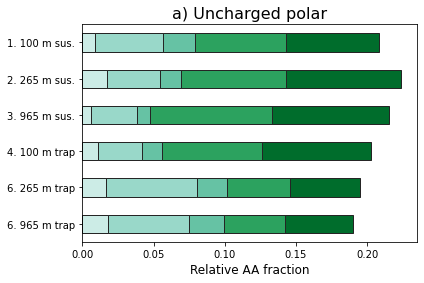

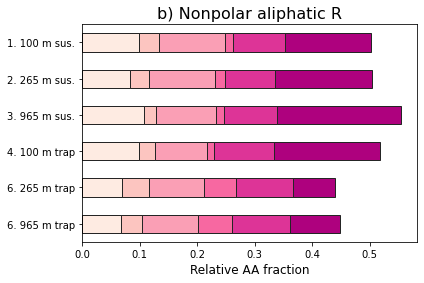

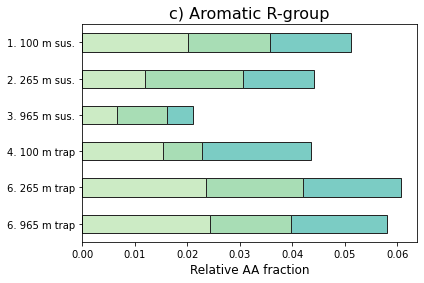

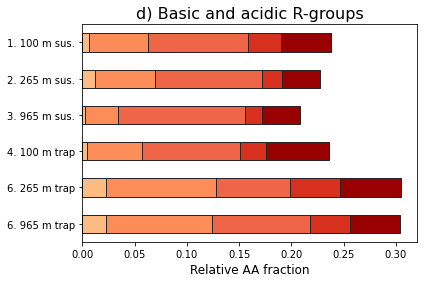

In [92]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

#plt.subplots(nrows=2, ncols=2)
#plt.subplots(figsize=(20,10)) 
#plt.tight_layout()

AA_RelNAAF50_sorted_desc= AA_RelNAAF50.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar
ax1 = AA_RelNAAF50_sorted_desc.plot.barh(y=['C_RelNAAF', \
                             'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', \
                             'T_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors1, edgecolor = '#252525')
ax1.legend_.remove()
ax1.set_xlabel('Relative AA fraction', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('a) Uncharged polar', fontsize = 16)


# nonpolar, aliphatic R-group
ax2 = AA_RelNAAF50_sorted_desc.plot.barh(y=['A_RelNAAF', \
                             'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF', \
                             'P_RelNAAF', \
                             'V_RelNAAF',\
                            ], x='data source', stacked=True, color = my_colors2, edgecolor = '#252525')
ax2.legend_.remove()
ax2.set_xlabel('Relative AA fraction', fontsize = 12)
ax2.set_ylabel('')
ax2.set_title('b) Nonpolar aliphatic R', fontsize = 16)

# aromatic R-group
ax3 = AA_RelNAAF50_sorted_desc.plot.barh(y=['F_RelNAAF', \
                              'W_RelNAAF', 'Y_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors3, edgecolor = '#252525')
ax3.legend_.remove()
ax3.set_xlabel('Relative AA fraction', fontsize = 12)
ax3.set_ylabel('')
ax3.set_title('c) Aromatic R-group', fontsize = 16)


# Basic and acidic R-group
ax4 = AA_RelNAAF50_sorted_desc.plot.barh(y=['H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 
                            'D_RelNAAF', 'E_RelNAAF', 
                            ], x='data source', stacked=True, color = my_colors4, edgecolor = '#252525')
ax4.legend_.remove()
ax4.set_xlabel('Relative AA fraction', fontsize = 12)
ax4.set_ylabel('')
ax4.set_title('d) Basic and acidic R-groups', fontsize = 16)


Text(0.5, 1.0, 'd) Basic and acidic R-groups')

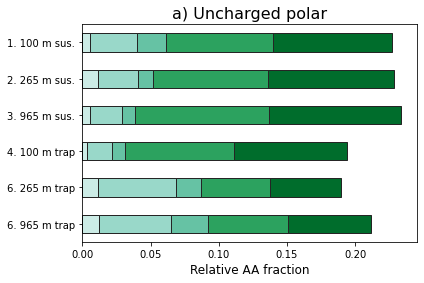

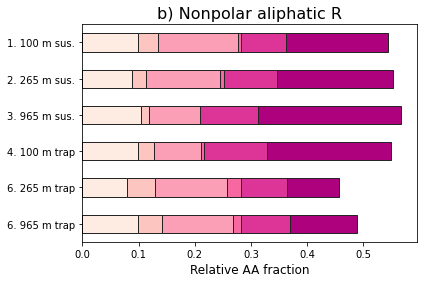

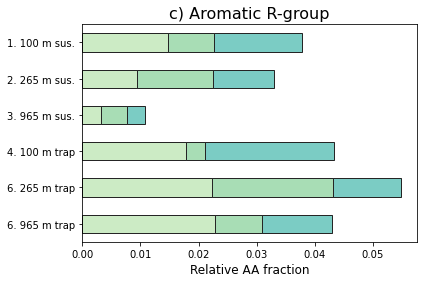

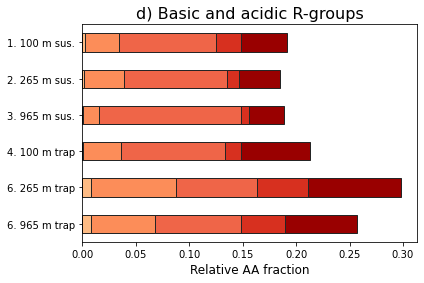

In [93]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

#plt.subplots(nrows=2, ncols=2)
#plt.subplots(figsize=(20,10)) 
#plt.tight_layout()

AA_RelNAAF80_sorted_desc= AA_RelNAAF80.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar
ax1 = AA_RelNAAF80_sorted_desc.plot.barh(y=['C_RelNAAF', \
                             'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', \
                             'T_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors1, edgecolor = '#252525')
ax1.legend_.remove()
ax1.set_xlabel('Relative AA fraction', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('a) Uncharged polar', fontsize = 16)


# nonpolar, aliphatic R-group
ax2 = AA_RelNAAF80_sorted_desc.plot.barh(y=['A_RelNAAF', \
                             'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF', \
                             'P_RelNAAF', \
                             'V_RelNAAF',\
                            ], x='data source', stacked=True, color = my_colors2, edgecolor = '#252525')
ax2.legend_.remove()
ax2.set_xlabel('Relative AA fraction', fontsize = 12)
ax2.set_ylabel('')
ax2.set_title('b) Nonpolar aliphatic R', fontsize = 16)

# aromatic R-group
ax3 = AA_RelNAAF80_sorted_desc.plot.barh(y=['F_RelNAAF', \
                              'W_RelNAAF', 'Y_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors3, edgecolor = '#252525')
ax3.legend_.remove()
ax3.set_xlabel('Relative AA fraction', fontsize = 12)
ax3.set_ylabel('')
ax3.set_title('c) Aromatic R-group', fontsize = 16)


# Basic and acidic R-group
ax4 = AA_RelNAAF80_sorted_desc.plot.barh(y=['H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 
                            'D_RelNAAF', 'E_RelNAAF', 
                            ], x='data source', stacked=True, color = my_colors4, edgecolor = '#252525')
ax4.legend_.remove()
ax4.set_xlabel('Relative AA fraction', fontsize = 12)
ax4.set_ylabel('')
ax4.set_title('d) Basic and acidic R-groups', fontsize = 16)


In [94]:
# plot NAAF-corrected AA compositions in a heatmap

AA_RelNAAF50.style.background_gradient(cmap ='viridis')

,data source,A_RelNAAF,C_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,N_RelNAAF,P_RelNAAF,Q_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,W_RelNAAF,Y_RelNAAF
0,1. 100 m sus.,0.099427,0.008804,0.031049,0.047691,0.020153,0.034264,0.006774,0.056061,0.114442,0.014728,0.047836,0.089300,0.022520,0.096013,0.064214,0.064663,0.151073,0.015679,0.015307
1,2. 265 m sus.,0.082760,0.017340,0.018286,0.037048,0.011857,0.032587,0.012530,0.057128,0.116466,0.015960,0.037076,0.088499,0.014886,0.102679,0.073535,0.081106,0.167875,0.018761,0.013620
2,3. 965 m sus.,0.107809,0.005831,0.016954,0.036229,0.006577,0.021068,0.002324,0.031673,0.103640,0.013477,0.032497,0.093223,0.009214,0.121343,0.085447,0.082283,0.215866,0.009582,0.004965
3,4. 100 m trap,0.099435,0.010677,0.024534,0.060665,0.015329,0.027619,0.004064,0.052805,0.090155,0.011831,0.031569,0.104049,0.013943,0.093867,0.070001,0.076831,0.184383,0.007474,0.020768
4,6. 265 m trap,0.069554,0.016779,0.048178,0.058298,0.023661,0.046092,0.022883,0.104750,0.096743,0.054981,0.064045,0.100114,0.021027,0.070937,0.044063,0.048776,0.072007,0.018372,0.018742
5,6. 965 m trap,0.067653,0.018378,0.038897,0.047208,0.024374,0.037070,0.022823,0.100966,0.097329,0.058419,0.056458,0.101531,0.024421,0.093713,0.042744,0.047948,0.086373,0.015361,0.018334


In [95]:
# plot NAAF-corrected AA compositions in a heatmap

AA_RelNAAF80.style.background_gradient(cmap ='viridis')

,data source,A_RelNAAF,C_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,N_RelNAAF,P_RelNAAF,Q_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,W_RelNAAF,Y_RelNAAF
0,1. 100 m sus.,0.098367,0.005455,0.022891,0.043010,0.014654,0.036787,0.002145,0.032217,0.141682,0.005862,0.034863,0.078850,0.021221,0.090793,0.078008,0.087513,0.182621,0.007970,0.015091
1,2. 265 m sus.,0.088479,0.011518,0.010530,0.038735,0.009330,0.024330,0.001127,0.038245,0.132669,0.005973,0.029247,0.095490,0.010857,0.096421,0.084732,0.092424,0.206274,0.013217,0.010400
2,3. 965 m sus.,0.105176,0.005617,0.007187,0.032230,0.003285,0.014093,0.000182,0.015033,0.089445,0.000467,0.023804,0.102887,0.008898,0.133646,0.098661,0.096832,0.255065,0.004327,0.003163
3,4. 100 m trap,0.098916,0.003785,0.014521,0.065110,0.017801,0.029047,0.000431,0.035312,0.083784,0.004153,0.017651,0.113052,0.009867,0.097911,0.080205,0.082217,0.220765,0.003333,0.022140
4,6. 265 m trap,0.079964,0.011685,0.047566,0.087250,0.022303,0.048584,0.007661,0.080382,0.128098,0.024707,0.056711,0.083178,0.018757,0.075480,0.050158,0.052147,0.092826,0.020853,0.011691
5,6. 965 m trap,0.098664,0.012372,0.040959,0.067781,0.022797,0.042283,0.007767,0.059923,0.126924,0.013811,0.052465,0.087002,0.027342,0.080851,0.058829,0.061028,0.119124,0.008098,0.011980


### Same process for NAAF-corrected PTM occurance

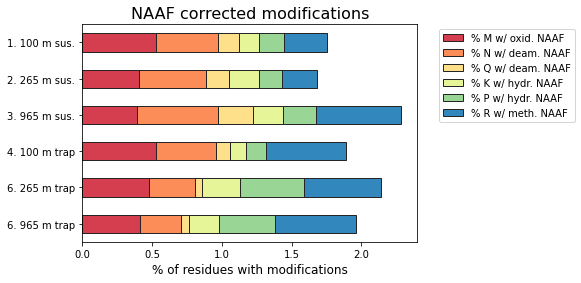

In [96]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

PTM_NAAF50_sorted_desc= PTM_NAAF50.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_c = '#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax = PTM_NAAF50_sorted_desc.plot.barh(y=['% M w/ oxid. NAAF', \
                                           '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                                           '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF'
                            ], x='data source', stacked=True, color = divergent_c, edgecolor = '#252525')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('% of residues with modifications', fontsize = 12)
ax.set_ylabel('')
ax.set_title('NAAF corrected modifications', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/percent-skq17-ptms-DN50", transparent=True)

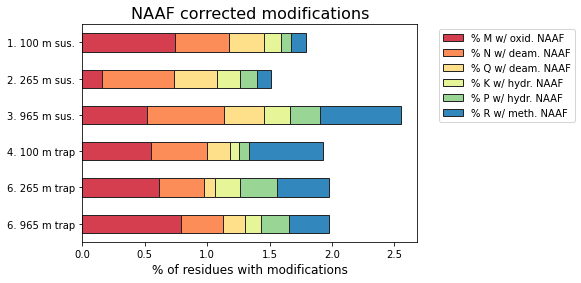

In [97]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

PTM_NAAF80_sorted_desc= PTM_NAAF80.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_c = '#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax = PTM_NAAF80_sorted_desc.plot.barh(y=['% M w/ oxid. NAAF', \
                                           '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                                           '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF'
                            ], x='data source', stacked=True, color = divergent_c, edgecolor = '#252525')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('% of residues with modifications', fontsize = 12)
ax.set_ylabel('')
ax.set_title('NAAF corrected modifications', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/percent-skq17-ptms-DN80", transparent=True)

### Absolute PTM occurance

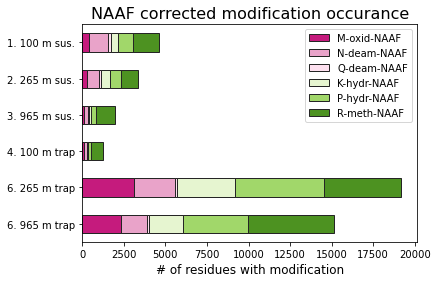

In [98]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

NAAFtot50_sorted_desc= NAAFtot50.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_6 = '#c51b7d', '#e9a3c9', '#fde0ef', '#e6f5d0', '#a1d76a', '#4d9221'


# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax1 = NAAFtot50_sorted_desc.plot.barh(y=['M-oxid-NAAF', 'N-deam-NAAF', \
                                            'Q-deam-NAAF', 'K-hydr-NAAF', \
                                            'P-hydr-NAAF', 'R-meth-NAAF'
                            ], x='data source', stacked=True, color = divergent_6, edgecolor = '#252525')

ax1.legend()
ax1.set_xlabel('# of residues with modification', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('NAAF corrected modification occurance', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/absolute-skq17-ptms-DN50", figsize=(15,10), transparent=True)

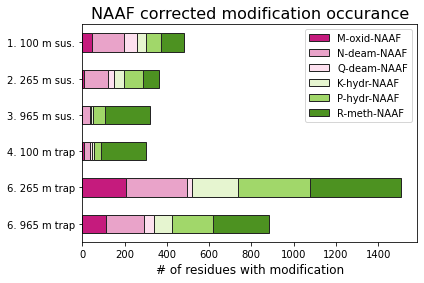

In [99]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

NAAFtot80_sorted_desc= NAAFtot80.sort_values('data source', ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_6 = '#c51b7d', '#e9a3c9', '#fde0ef', '#e6f5d0', '#a1d76a', '#4d9221'


# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar

ax1 = NAAFtot80_sorted_desc.plot.barh(y=['M-oxid-NAAF', 'N-deam-NAAF', \
                                            'Q-deam-NAAF', 'K-hydr-NAAF', \
                                            'P-hydr-NAAF', 'R-meth-NAAF'
                            ], x='data source', stacked=True, color = divergent_6, edgecolor = '#252525')

ax1.legend()
ax1.set_xlabel('# of residues with modification', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('NAAF corrected modification occurance', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/absolute-skq17-ptms-DN80", figsize=(15,10), transparent=True)

## Now for Comet AA and PTM NAAF-corrected results:

Text(0.5, 1.0, 'd) Basic and acidic R-groups')

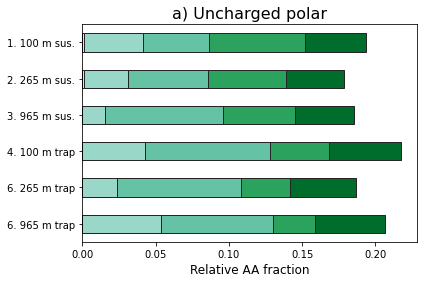

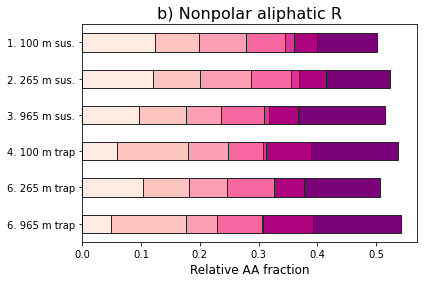

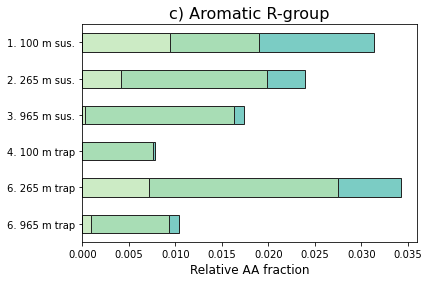

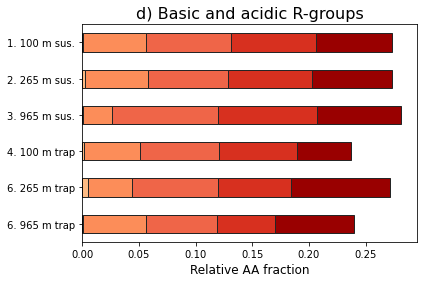

In [100]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

#plt.subplots(nrows=2, ncols=2)
#plt.subplots(figsize=(20,10)) 
#plt.tight_layout()

comet_AA_RelNAAF_sorted_desc= comet_AA_RelNAAF.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e', '#7a0177'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar
ax1 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['C_RelNAAF', \
                             'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', \
                             'T_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors1, edgecolor = '#252525')
ax1.legend_.remove()
ax1.set_xlabel('Relative AA fraction', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('a) Uncharged polar', fontsize = 16)


# nonpolar, aliphatic R-group
ax2 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['A_RelNAAF', \
                             'G_RelNAAF','I_RelNAAF', 'L_RelNAAF', 'M_RelNAAF', \
                             'P_RelNAAF', \
                             'V_RelNAAF',\
                            ], x='data source', stacked=True, color = my_colors2, edgecolor = '#252525')
ax2.legend_.remove()
ax2.set_xlabel('Relative AA fraction', fontsize = 12)
ax2.set_ylabel('')
ax2.set_title('b) Nonpolar aliphatic R', fontsize = 16)

# aromatic R-group
ax3 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['F_RelNAAF', \
                              'W_RelNAAF', 'Y_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors3, edgecolor = '#252525')
ax3.legend_.remove()
ax3.set_xlabel('Relative AA fraction', fontsize = 12)
ax3.set_ylabel('')
ax3.set_title('c) Aromatic R-group', fontsize = 16)


# Basic and acidic R-group
ax4 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 
                            'D_RelNAAF', 'E_RelNAAF', 
                            ], x='data source', stacked=True, color = my_colors4, edgecolor = '#252525')
ax4.legend_.remove()
ax4.set_xlabel('Relative AA fraction', fontsize = 12)
ax4.set_ylabel('')
ax4.set_title('d) Basic and acidic R-groups', fontsize = 16)


### Same process for Comet NAAF-corrected PTM occurance

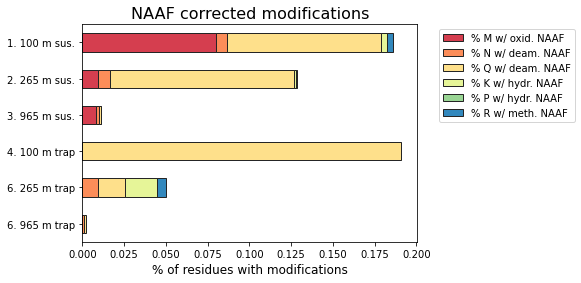

In [101]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

comet_PTM_NAAF_sorted_desc= comet_PTM_NAAF.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_c = '#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax = comet_PTM_NAAF_sorted_desc.plot.barh(y=['% M w/ oxid. NAAF', \
                                           '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                                           '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF'
                            ], x='data source', stacked=True, color = divergent_c, edgecolor = '#252525')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('% of residues with modifications', fontsize = 12)
ax.set_ylabel('')
ax.set_title('NAAF corrected modifications', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/percent-skq17-ptms-comet3", transparent=True)

### Absolute PTM occurance for Comet results

In [39]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

comet_PTM_NAAF_sorted_desc= comet_PTM_NAAF.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_6 = '#c51b7d', '#e9a3c9', '#fde0ef', '#e6f5d0', '#a1d76a', '#4d9221'


# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax1 = comet_PTM_NAAF_sorted_desc.plot.barh(y=['M-oxid-NAAF', 'N-deam-NAAF', \
                                            'Q-deam-NAAF', 'K-hydr-NAAF', \
                                            'P-hydr-NAAF', 'R-meth-NAAF'
                            ], x='data source', stacked=True, color = divergent_6, edgecolor = '#252525')

ax1.legend()
ax1.set_xlabel('# of residues with modification', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('NAAF corrected modification occurance', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/absolute-skq17-ptms-comet3", figsize=(15,10), transparent=True)

KeyError: "None of [Index(['M-oxid-NAAF', 'N-deam-NAAF', 'Q-deam-NAAF', 'K-hydr-NAAF',\n       'P-hydr-NAAF', 'R-meth-NAAF'],\n      dtype='object')] are in the [columns]"